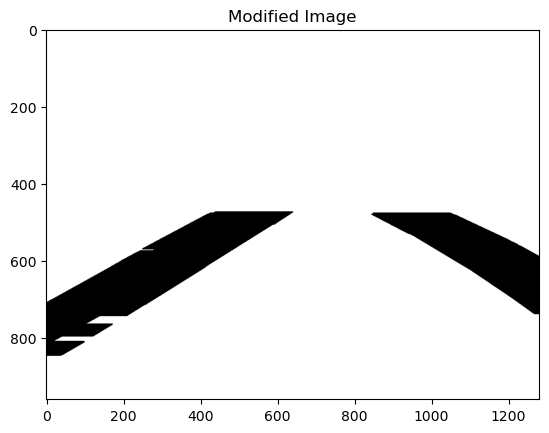

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked_img = cv2.bitwise_and(img, cv2.bitwise_not(mask))
    return masked_img

def split_lines(lines):
    left_lines = []
    right_lines = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1 + 1e-6)
            angle = np.arctan(slope) * 180 / np.pi

            if slope > 0:
                right_lines.append(line)
            elif slope < 0:
                left_lines.append(line)

    return left_lines, right_lines

def detect_curved_lines(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 100, 250)
    height, width = image.shape[:2]

    roi_vertices = np.array([[(width * 0, height), (width * 0.15, height * 0.775),
                              (width * 0.85, height * 0.775), (width * 1, height)]], dtype=np.int32)

    additional_roi_vertices = np.array([[(width * 0, height * 0), (width * 0, height * 0.45),
                                          (width * 1, height * 0.45), (width * 1, height * 0)]], dtype=np.int32)

    roi_vertices = np.concatenate((roi_vertices, additional_roi_vertices), axis=0)

    roi_edges = region_of_interest(edges, roi_vertices)

    lines = cv2.HoughLinesP(roi_edges, 1, np.pi / 180, threshold=20, minLineLength=40, maxLineGap=20)

    filtered_lines = []
    for line in lines:
        for x1, y1, x2, y2 in line:
            slope = (y2 - y1) / (x2 - x1 + 1e-6)
            angle = np.arctan(slope) * 180 / np.pi
            if 20 < angle < 70 or -70 < angle < -20:
                filtered_lines.append(line)

    left_lines, right_lines = split_lines(filtered_lines)

    line_image = np.zeros_like(image)

    for line in left_lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    for line in right_lines:
        for x1, y1, x2, y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)

    return line_image

def colorize_regions(lines_image, region_width=50):
    lines_image = np.array(lines_image)

    red_pixels = np.where(lines_image[:, :, 0] == 255)
    blue_pixels = np.where(lines_image[:, :, 2] == 255)

    modified_image = lines_image.copy()

    for i in range(len(red_pixels[0])):
        row, col = red_pixels[0][i], red_pixels[1][i]
        start_col = max(0, col - region_width)
        end_col = col
        modified_image[row, start_col:end_col, :] = [0, 0, 255]

    for i in range(len(blue_pixels[0])):
        row, col = blue_pixels[0][i], blue_pixels[1][i]
        start_col = col + 1
        end_col = min(lines_image.shape[1], col + 1 + region_width)
        modified_image[row, start_col:end_col, :] = [255, 0, 0]

    black_pixels = np.where(np.all(modified_image == [0, 0, 0], axis=-1))
    modified_image = np.ones_like(lines_image) * 0
    modified_image[black_pixels] = [255, 255, 255]

    return modified_image

def process_image(image_path):
    image = cv2.imread(image_path)
    lines_result = detect_curved_lines(image)
    modified_image = colorize_regions(lines_result, region_width=200)
    return modified_image

# Example usage:
image_path = '/home/neli/labelneu/storage_backup/images_15_11_2/frame584.jpg'
result = process_image(image_path)
plt.imshow(result)
plt.title('Modified Image')
plt.show()
